In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

from torchvision import datasets, transforms
import tqdm
from torchvision.utils import make_grid

import torch.distributions as tdist

import numpy as np
import tqdm

import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
class VAE(nn.Module):
    
    def __init__(self, latent_size, input_size, output_size, hidden_size):
        super(VAE, self).__init__()
        
        self.latent_size = latent_size
        
        self.enc1 = nn.Linear(input_size, hidden_size)
        self.enc2 = nn.Linear(hidden_size, hidden_size)
        self.dec1 = nn.Linear(latent_size, hidden_size)
        self.dec2 = nn.Linear(hidden_size, hidden_size)
        
        self.softplus = nn.Softplus()

        self.mu = nn.Linear(hidden_size, latent_size)
        self.var = nn.Linear(hidden_size, latent_size)

        self.mu_dec = nn.Linear(hidden_size, output_size)
        self.var_dec = nn.Linear(hidden_size, output_size)
        
    def encode(self, x):
        x = self.enc1(x)
        x = self.softplus(x)
        x = self.enc2(x)
        x = self.softplus(x)
        mu = self.mu(x)
        logvar = torch.log(1e-6 + self.softplus(self.var(x)))
        return mu, logvar
        
    def reparametrize(self, mu, logvar):
        return mu + torch.exp(logvar) * torch.randn_like(mu)
    
    def decode(self, z):
        z = self.dec1(z)
        z = self.softplus(z)
        z = self.dec2(z)
        z = self.softplus(z)
        mu = self.mu_dec(z)
        logvar = torch.log(1e-6 + self.softplus(self.var_dec(z)))
        out = self.reparametrize(mu, logvar)
        return torch.sigmoid(out)
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparametrize(mu, logvar)
        reconstruction = self.decode(z)
        return reconstruction, z, mu, logvar
    
    @staticmethod
    def loss_fn(reconstruction, batch, mu, logvar):
        crossentropy = F.binary_cross_entropy(reconstruction, batch.view(-1, 784), reduction='sum') / batch.shape[0]
        kl_div = 0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar)) / batch.shape[0]
        return crossentropy - kl_div

In [0]:
def prepare_data_loaders(batch_size=32):
    train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor()
                               ])), batch_size=batch_size)

    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./files', train=False, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor()
                                   ])), batch_size=batch_size)
    
    return train_loader, test_loader

def train(model, n_epochs=10, log_epochs=1, batch_size=32, learning_rate=1e-3, device='cpu'):
    train_loader, test_loader = prepare_data_loaders(batch_size)
    
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    
    for epoch_idx in range(0, n_epochs):
        
        train_loss = 0
        for batch_idx, (image_data, _) in enumerate(train_loader):
            image_data = image_data.to(device)
            
            optimizer.zero_grad()
            reconstructed_batch, batch_z, batch_mu, batch_logvar = model(image_data)
            loss = model.loss_fn(reconstructed_batch, image_data, batch_mu, batch_logvar)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        if epoch_idx % log_epochs == 0:
            print(f"Epoch {epoch_idx+1}/{n_epochs}: {train_loss / (len(train_loader) * train_loader.batch_size):.2f}")
            
    model.eval()
    
    return model

def plot_reconstructions(device='cpu', number_of_samples=10, state_shape=(4, 5)):
    train_loader, test_loader = prepare_data_loaders(batch_size=number_of_samples)
    batch, _ = next(iter(test_loader))
    recons, zs, mus, logvars = model(batch.to(device))
    
    for idx in range(0, number_of_samples):
        original_image = batch[idx, ...].view(28, 28).data.cpu()
        recon_image = recons[idx, ...].view(28, 28).data.cpu()
        state = zs[idx, ...].view(*state_shape).data.cpu()

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(original_image)

        plt.subplot(1, 3, 2)
        plt.imshow(recon_image)
        
        plt.subplot(1, 3, 3)
        plt.imshow(state)
        plt.clim(-4, 4)
        plt.colorbar()

def generate_latent_dataframes(data_loader):
    mu_acc = []
    logvar_acc = []
    label_acc = []

    for image_data, label in tqdm.tqdm(data_loader):
        mu, logvar = model.encode(image_data.view(-1, 784).to('cuda'))

        mu_acc.extend(mu.data.cpu().numpy())
        logvar_acc.extend(logvar.data.cpu().numpy())
        label_acc.extend(label.data.cpu().numpy())

    mu_acc = np.array(mu_acc)
    logvar_acc = np.array(logvar_acc)


    tmp = {
        'label': label_acc
    }
    for idx in range(0, mu_acc.shape[1]):
        tmp[f'mu_z{idx}'] = mu_acc[..., idx]

    df_mu = pd.DataFrame(tmp)
    df_mu['label'] = df_mu['label'].astype('category')


    tmp = {
        'label': label_acc
    }
    for idx in range(0, mu_acc.shape[1]):
        tmp[f'logvar_z{idx}'] = np.square(np.exp(logvar_acc[..., idx]))

    df_logvar = pd.DataFrame(tmp)
    df_logvar['label'] = df_logvar['label'].astype('category')


    tmp = {}
    for idx in range(0, model.dec1.weight.T.shape[0]):
        tmp[f'w{idx}'] = list(model.dec1.weight.T[idx, ...].data.cpu().numpy())

    df_dec1_weights = pd.DataFrame(tmp)
    
    return df_mu, df_logvar, df_dec1_weights


def plot_data_boxplots(df_mu, df_logvar, df_dec1_weights, baseline_figsize=(1.2, 6)):
    figwidth, figheight = baseline_figsize
    df_mu2 = df_mu.melt(['label'])
    plt.figure(figsize=(int(figwidth * LATENT_SIZE), figheight))
    sns.boxplot(x='variable', y='value', data=df_mu2)
    plt.title("Distribution of $\mu$ in latent space")

    df_logvar2 = df_logvar.melt(['label'])
    plt.figure(figsize=(int(figwidth * LATENT_SIZE), figheight))
    sns.boxplot(x='variable', y='value', data=df_logvar2)
    plt.title("Distribution of $\sigma^2$ in latent space")

    df_dec1_weights2 = df_dec1_weights.melt()
    plt.figure(figsize=(int(figwidth * LATENT_SIZE), figheight))
    sns.boxplot(x='variable', y='value', data=df_dec1_weights2)
    plt.title("Weights going to decoder from latent space")


def walk_in_latent_space(latent_space_abs_limit=3, sqrt_sample_count=20, latent_size=2, dimensions_to_walk=(0, 1), figsize=(16, 16)):
    dim1, dim2 = dimensions_to_walk
    canvas = np.zeros((sqrt_sample_count * 28, sqrt_sample_count * 28))

    synthetic_representations = np.zeros((sqrt_sample_count * sqrt_sample_count, latent_size))

    synthetic_representations[..., dim1] = np.linspace(-latent_space_abs_limit, latent_space_abs_limit, num=sqrt_sample_count * sqrt_sample_count)
    synthetic_representations[..., dim2] = np.linspace(-latent_space_abs_limit, latent_space_abs_limit, num=sqrt_sample_count * sqrt_sample_count)

    recons = model.decode(torch.from_numpy(synthetic_representations).float().to('cuda'))

    for idx in range(0, sqrt_sample_count * sqrt_sample_count):
        x, y = np.unravel_index(idx, (sqrt_sample_count, sqrt_sample_count))
        canvas[y*28:((y+1) * 28), x*28:((x+1) * 28)] = recons[idx, ...].view(28, 28).data.cpu().numpy()

    plt.figure(figsize=figsize)
    plt.imshow(canvas)

In [5]:
LATENT_SIZE = 20
input_size = output_size = 784
model = VAE(LATENT_SIZE, input_size, output_size, hidden_size=200)
model = train(model, batch_size=1024, device='cuda', n_epochs=100, log_epochs=10, learning_rate=3.24e-4)

Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw



Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw


Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw


Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Epoch 1/100: 0.30
Epoch 11/100: 0.17
Epoch 21/100: 0.13
Epoch 31/100: 0.12
Epoch 41/100: 0.11
Epoch 51/100: 0.11
Epoch 61/100: 0.10
Epoch 71/100: 0.10
Epoch 81/100: 0.10
Epoch 91/100: 0.10


100%|██████████| 313/313 [00:00<00:00, 375.25it/s]


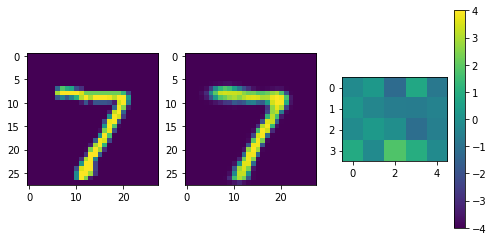

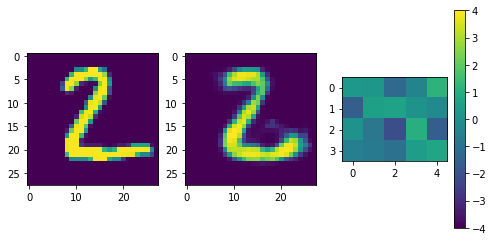

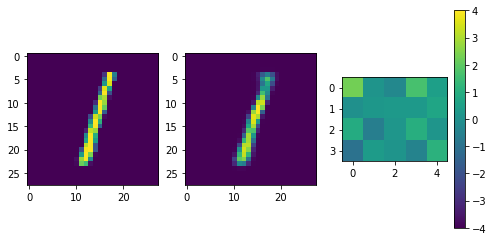

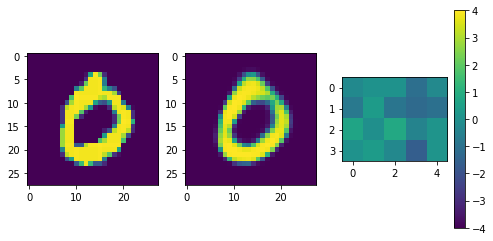

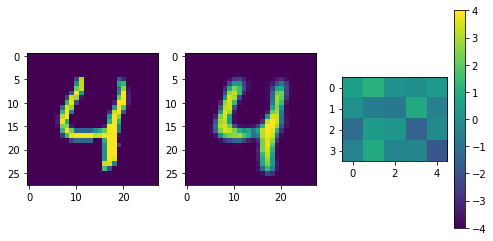

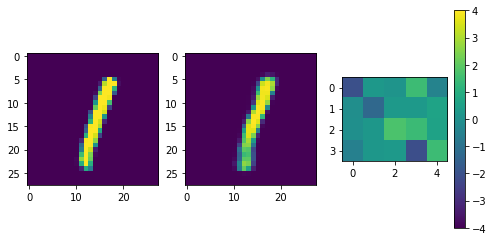

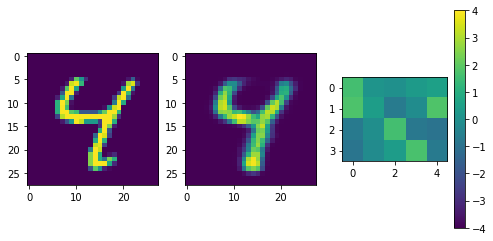

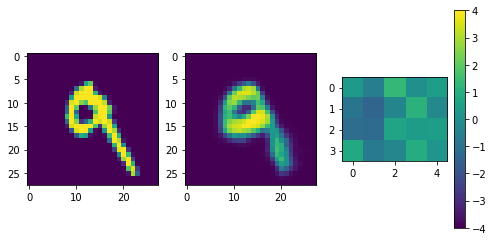

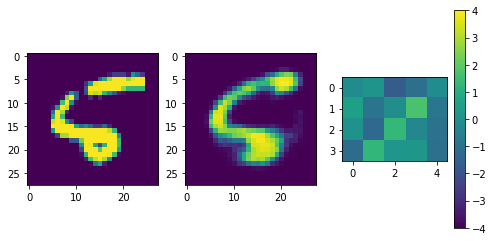

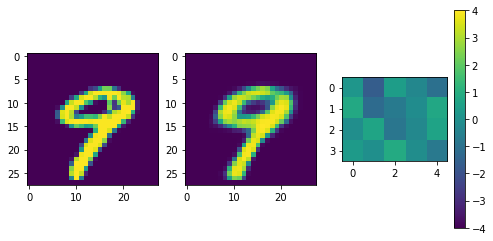

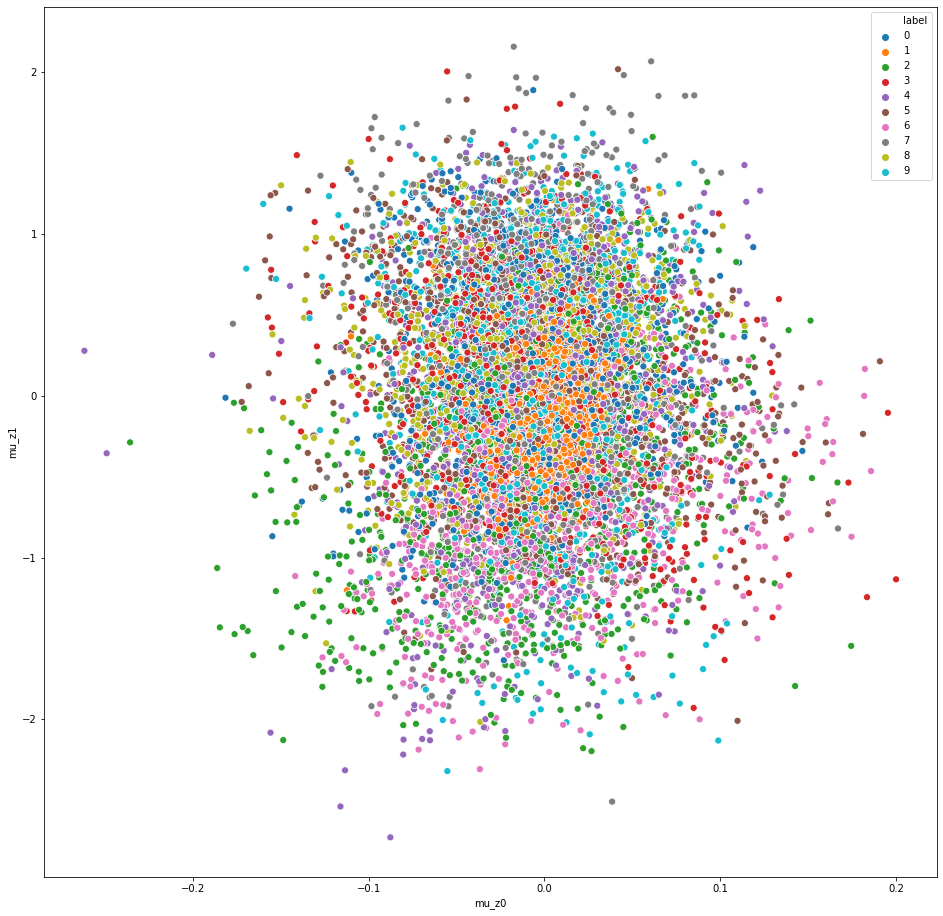

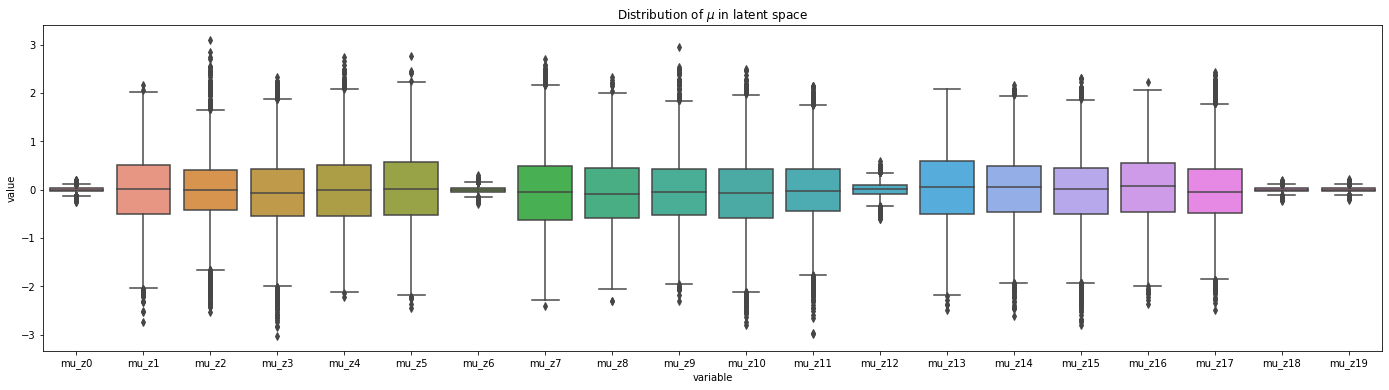

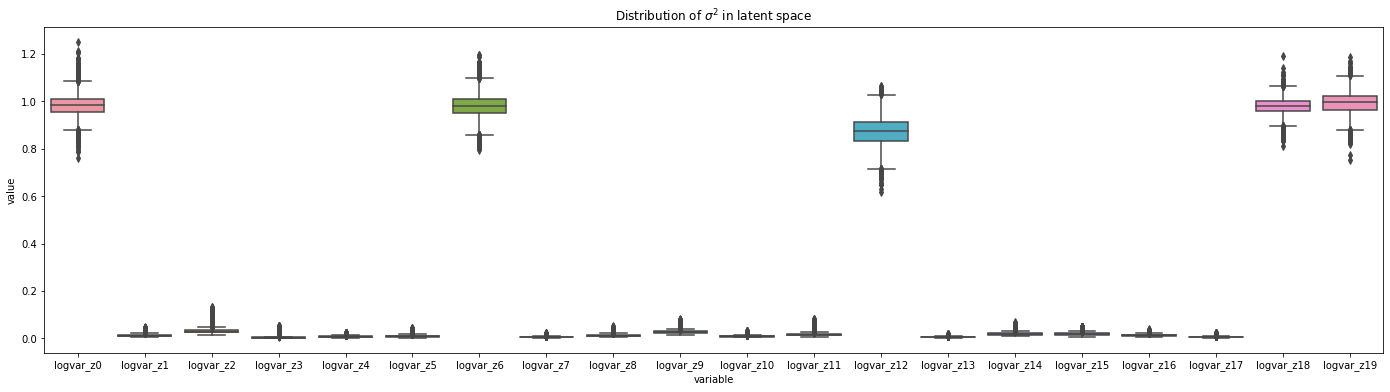

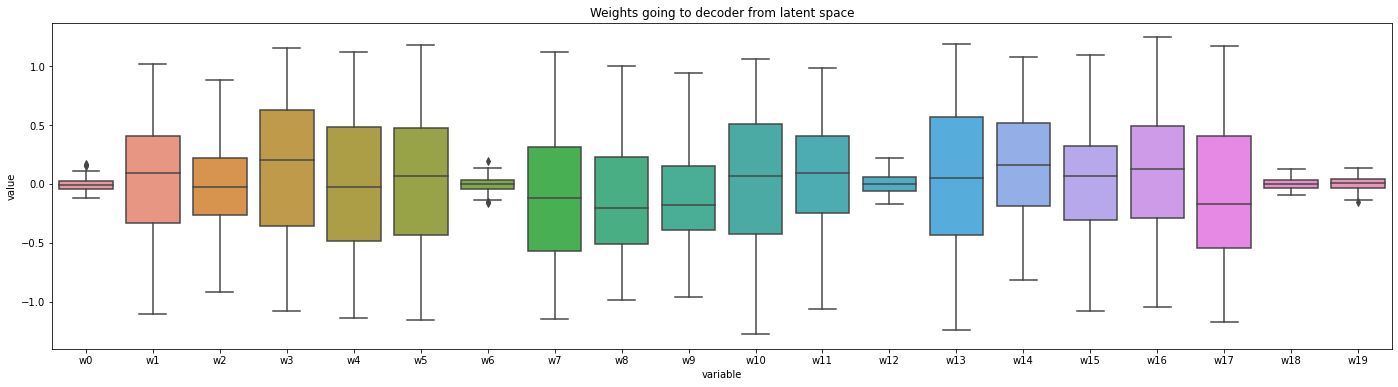

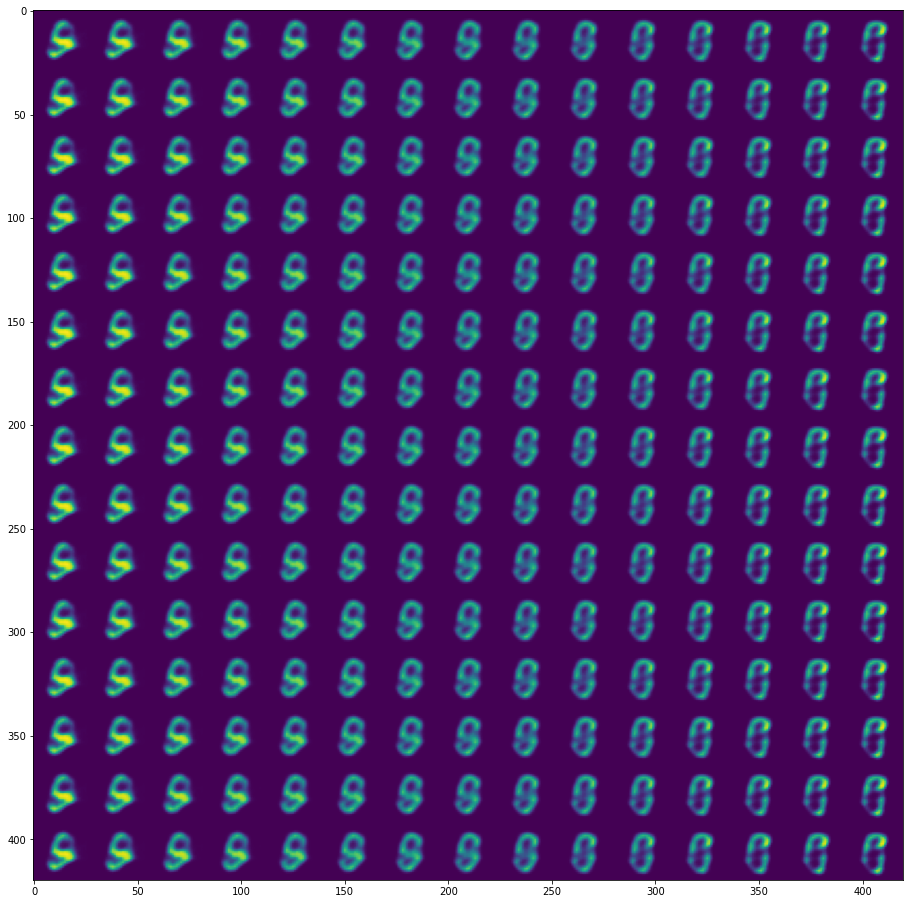

In [6]:
plot_reconstructions('cuda')

_, test_loader = prepare_data_loaders()
df_mu, df_logvar, df_dec1_weights = generate_latent_dataframes(test_loader)
plt.figure(figsize=(16, 16))
sns.scatterplot(x='mu_z0', y='mu_z1', hue='label', s=50, data=df_mu)

plot_data_boxplots(df_mu, df_logvar, df_dec1_weights)

walk_in_latent_space(latent_space_abs_limit=1.5, sqrt_sample_count=15, latent_size=LATENT_SIZE, dimensions_to_walk=(0,1))